# Well Log Data Classification Using Machine Learning Techniques

In this post, we will demonstrates how to train a machine learning algorithm to predict facies from well log data. This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

This experiment is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see Bohling and Dubois (2003) and Dubois et al. (2007).

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core. We will use this log data to train a support vector machine as our base model to classify facies types. Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks. The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case). We will use the SVM implementation in scikit-learn.

First we will carry out exploratory data analysis of the dataset. We will load the training data from 9 wells, and take a look at what we have to work with. We will plot the data from a couple wells, and create cross plots to look at the variation within the data.

Next we will condition the data set. We will remove the entries that have incomplete data. The data will be scaled to have zero mean and unit variance. We will also split the data into training and test sets.

We will then be ready to build the SVM classifier. We will demonstrate how to use the cross validation set to do model parameter selection.

Finally, once we have a built and tuned the classifier, we can apply the trained model to classify facies in wells which do not already have labels. We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.


## Exploratory Data Analysis

First, we will examine the data set we will use to train the classifier. The training data is contained in the file facies_vectors.csv. The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type). We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

**Five wire line log measurements include:**

1. [Gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), 
2. [Resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
3. [Photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), 
4. [Neutron-density porosity difference](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI) and
5. [Average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (PHIND). 

Note, some wells do not have PE.

** Two geologic constraining(Indicator) variables:** 

1. Nonmarine-marine indicator (NM_M) and 
2. Relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

In [1]:
#Import packages and libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from __future__ import division
mpl.rcParams['figure.figsize']=(20.0,10.0)
inline_rc = dict(mpl.rcParams)

from pandas import set_option
set_option("display.max_rows", 10)
pd.set_option('display.width', 1000)

Facies names

In [2]:
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_labels = ['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
facies = pd.DataFrame({'ShortName': pd.Series(facies_labels,index=facies_labels),'Facies' : pd.Series(['Nonmarine sandstone', 'Nonmarine coarse siltstone', 'Nonmarine fine siltstone ', 'Marine siltstone and shale', 'Mudstone (limestone)',  'Wackestone (limestone)', 'Dolomite', 'Packstone-grainstone (limestone)','Phylloid-algal bafflestone (limestone)'],index=facies_labels), 'Neighbours' : pd.Series(['CSiS',['SS','FSiS'],'CSiS','MS',['SiSh','WS'],['MS','D'],['WS','PS'],['WS','D','BS'],['D','PS']],index=facies_labels), 'Colors' : pd.Series(['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D'],index=facies_labels)})

## Load data
Let us load training data and store features, labels and other data into numpy arrays.

In [3]:
train_df = pd.read_csv('facies_vectors.csv')
train_df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


The following tables list the facies, their abbreviated labels and their approximate neighbors.

In [4]:
facies[['Facies']]

,Facies
SS,Nonmarine sandstone
CSiS,Nonmarine coarse siltstone
FSiS,Nonmarine fine siltstone
SiSh,Marine siltstone and shale
MS,Mudstone (limestone)
WS,Wackestone (limestone)
D,Dolomite
PS,Packstone-grainstone (limestone)
BS,Phylloid-algal bafflestone (limestone)


In [5]:
pd.DataFrame({'Neighbours' : [facies.ShortName[x] for x in facies.Neighbours]},index=facies_labels)

,Neighbours
SS,CSiS
CSiS,"SS SS FSiS FSiS Name: ShortName, dty..."
FSiS,CSiS
SiSh,MS
MS,"SiSh SiSh WS WS Name: ShortName, dty..."
WS,"MS MS D D Name: ShortName, dtype: object"
D,"WS WS PS PS Name: ShortName, dtype: object"
PS,"WS WS D D BS BS Name: ShortName, dt..."
BS,"D D PS PS Name: ShortName, dtype: object"


We are going to remove a single well to use for our blind test later

In [6]:
blind = train_df[train_df['Well Name'] == 'NEWBY']
train_df = train_df[train_df['Well Name'] != 'NEWBY']
train_df

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


The 'Well Name' and 'Formation' columns can be turned into a categorical data type.



In [7]:
train_df['Well Name'] = train_df['Well Name'].astype('category')
train_df['Formation'] = train_df['Formation'].astype('category')
train_df['Well Name'].unique()

/home/sudoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sudoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, CHURCHMAN BIBLE]
Categories (9, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., CROSS H CATTLE, NOLAN, Recruit F9, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir. Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone.

In [8]:
train_df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000,2769.000000,3686.000000,3686.000000
mean,4.465817,2902.517227,65.461666,0.657651,4.518612,13.398988,3.717207,1.506240,0.521062
std,2.495434,138.819109,29.822887,0.260786,5.300523,7.322523,0.943923,0.500029,0.286867
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2806.500000,45.570000,0.489000,1.700000,8.550250,3.078000,1.000000,0.274000
50%,4.000000,2931.000000,65.679500,0.635000,4.369000,12.172000,3.500000,2.000000,0.526000
75%,6.000000,3008.000000,80.205000,0.829000,7.600000,16.243500,4.371000,2.000000,0.767750
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [9]:
PE_mask = train_df['PE'].notnull().values
train_df = train_df[PE_mask]

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial. We also create the abbreviated facies labels, and add those to the facies_vectors dataframe.

In [10]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies.Colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] ]
    
train_df['Facies'] = train_df['Facies']-1
train_df.loc[:,'FaciesLabels'] = train_df.apply(lambda row: label_facies(row, facies_labels), axis=1)

rows = len(train_df.index)

processed_data = train_df.copy()

/home/sudoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sudoh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/sudoh/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels. The plots are based on the those described in Alessandro Amato del Monte's excellent tutorial.



In [11]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies.Colors[0:len(facies.Colors)], 'indexed')
    cmap_coarse = colors.ListedColormap(['#c0c0c0','#000000'])
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    #clustercoarse=np.repeat(np.expand_dims(logs['NM_M'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 16))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    
    
    im1 = ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)


    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im1, cax=cax)
    cbar.set_label((25*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    

    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    plt.show()

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells. The function was written to take a list of colors and facies labels as parameters.

Here are both the SHRIMPLIN and SHANKLE wells for your vieling pleasure.

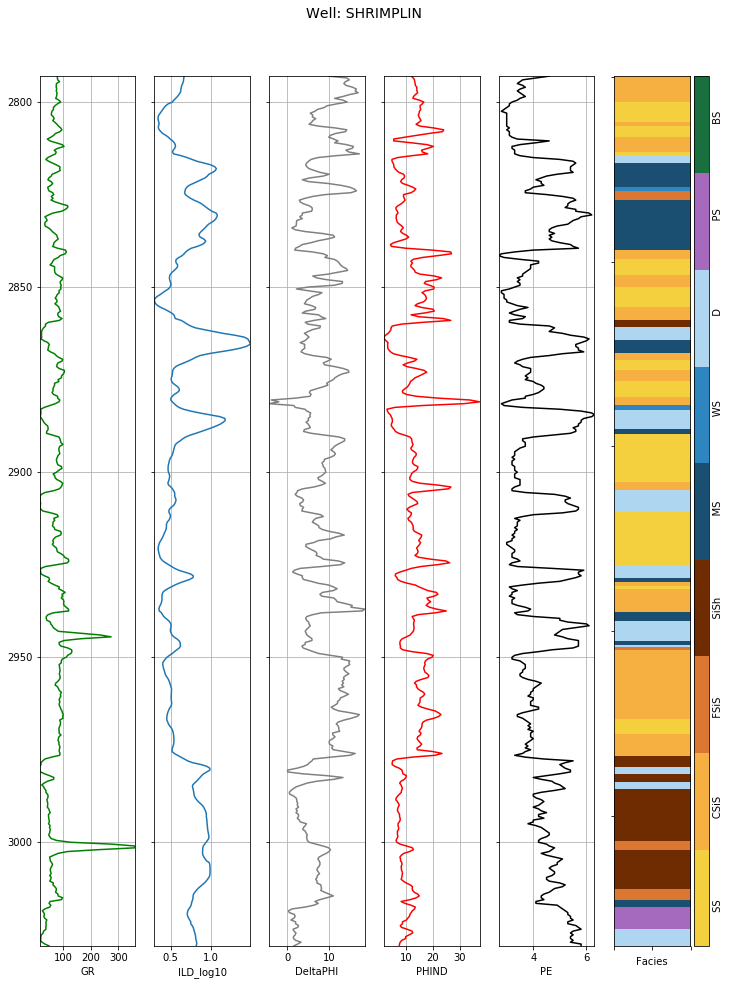

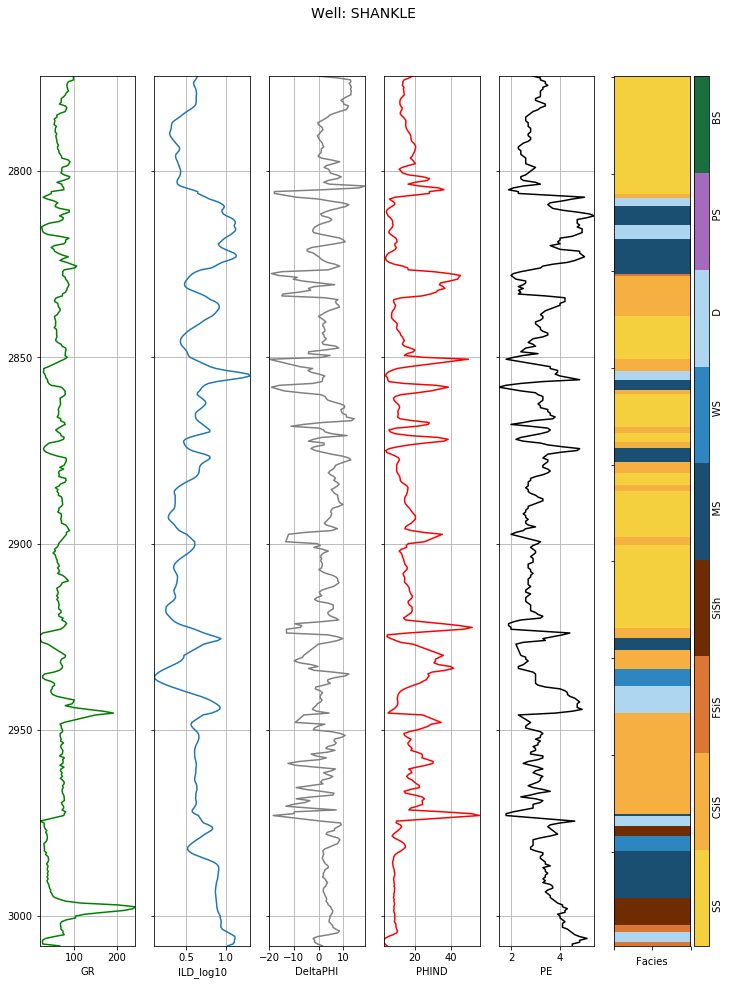

In [12]:

make_facies_log_plot(
    processed_data[processed_data['Well Name'] == 'SHRIMPLIN'],
    facies.Colors)

make_facies_log_plot(
    processed_data[processed_data['Well Name'] == 'SHANKLE'],
    facies.Colors)
mpl.rcParams.update(inline_rc)

In addition to individual wells, we can look at how the various facies are represented by the entire training set. Let's plot a histgram of the number of training examples for each facies class.

SS      259
CSiS    640
FSiS    535
SiSh    126
MS      189
WS      366
D        82
PS      442
BS      130
Name: Facies, dtype: int64

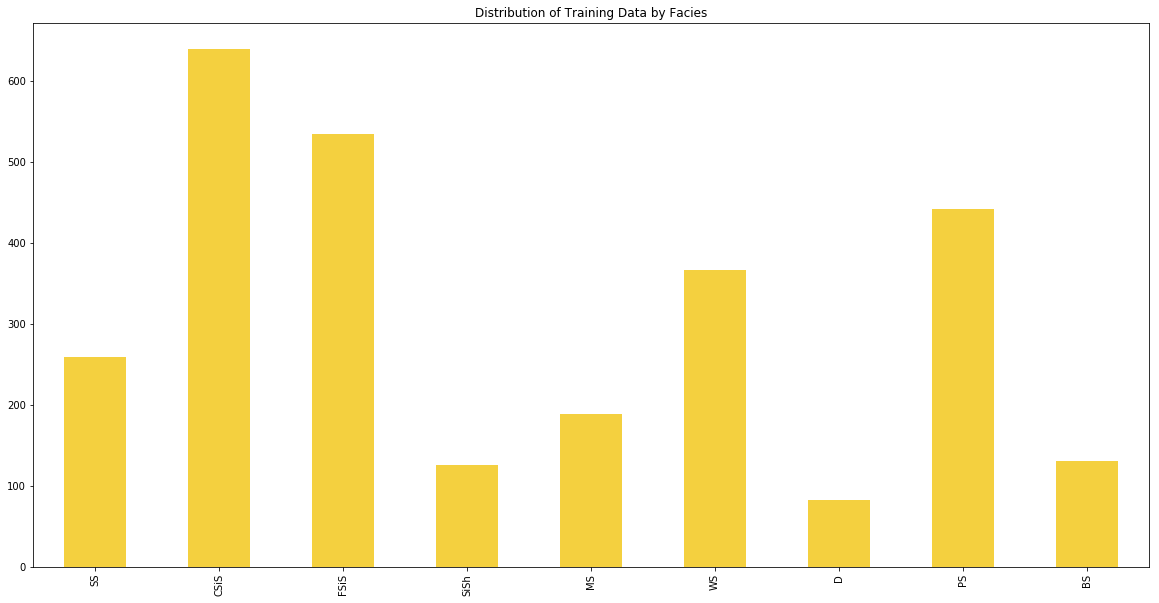

In [13]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D','PS', 'BS']

facies_counts = train_df['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color = facies_colors, title='Distribution of Training Data by Facies')
facies_counts

This shows the distribution of examples by facies for the 3232 training examples in the training set. Dolomite (facies 7) has the fewest with 141 examples. There are also only 185 bafflestone examples. Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset. We can employ the very useful Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 9 facies.

In [14]:
X = train_df[feature_names].values
# XplusFacies = data[featurePlusFacies_names].values
y = train_df['Facies'].values

In [20]:
# Define function for plotting feature statistics
import seaborn as sns

def plot_feature_stats(X, y, feature_names, facies_colors, facies_labels):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_labels):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_labels):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_labels)))

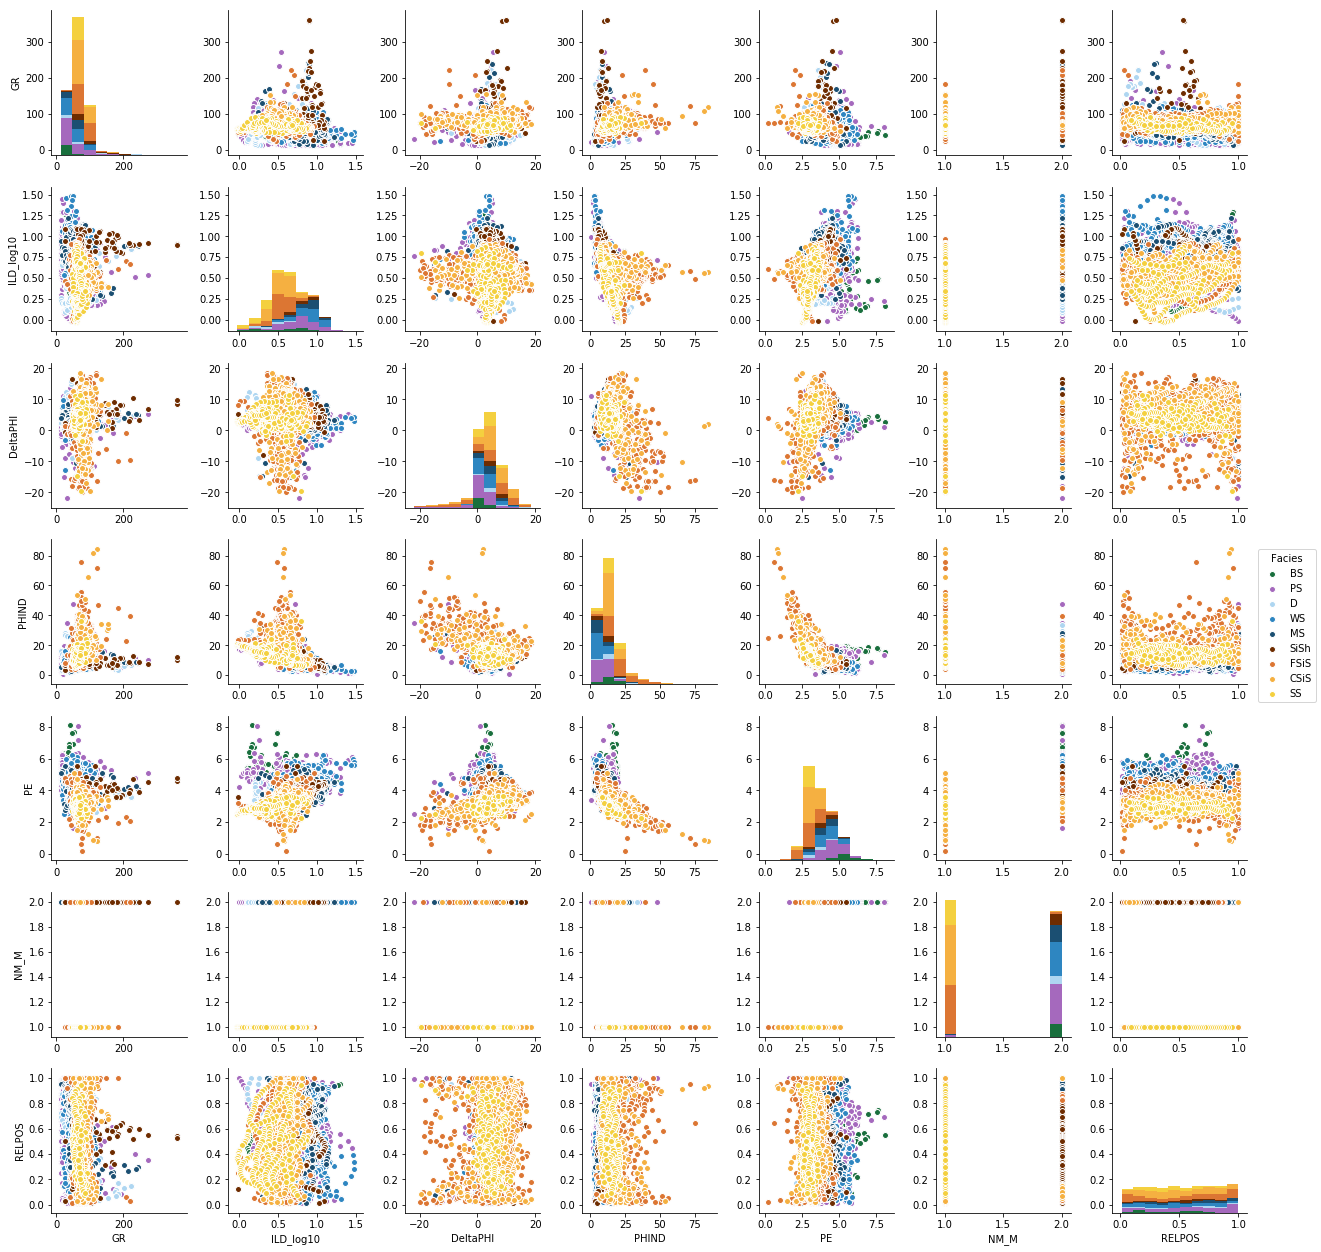

In [21]:
# Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_labels)
mpl.rcParams.update(inline_rc)

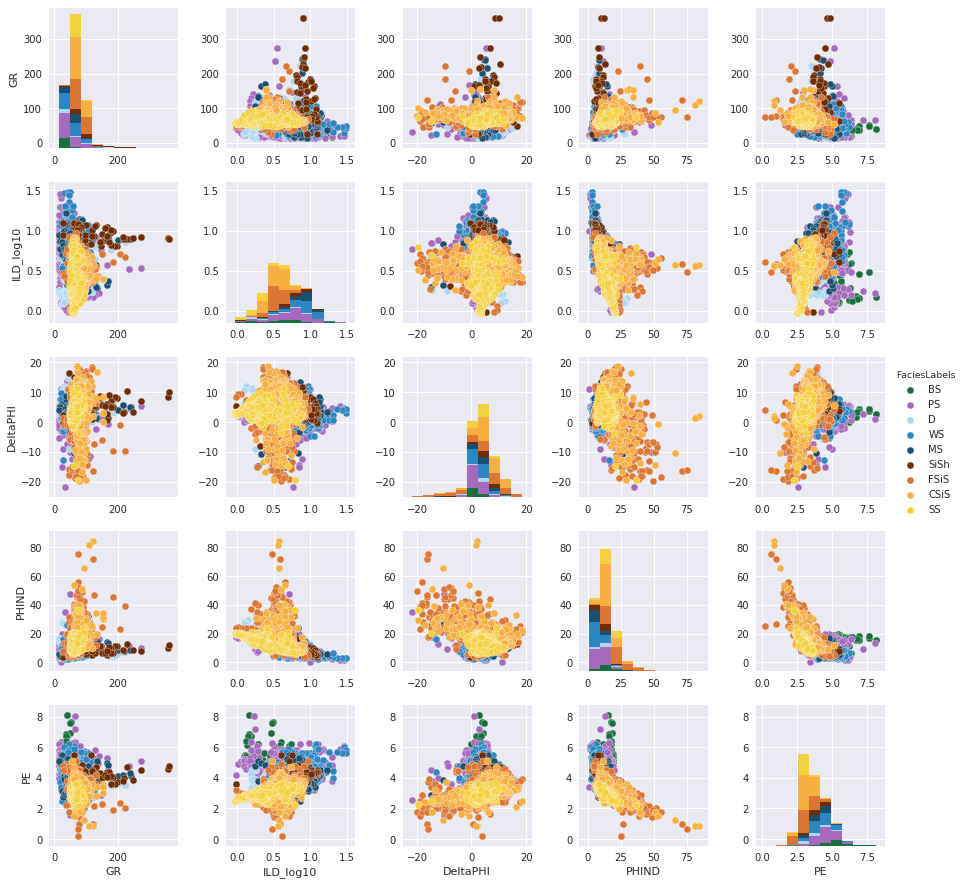

In [22]:
import seaborn as sns
sns.set()
sns.pairplot(train_df.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Dataset Conditioning

Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [23]:
correct_facies_labels = train_df['Facies'].values

feature_vectors = train_df.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,67.039150,0.637353,3.573298,13.793859,3.717207,1.478873,0.518975
std,30.280378,0.250915,5.270749,8.007659,0.943923,0.499644,0.287105
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,48.125000,0.479863,1.211000,8.450000,3.078000,1.000000,0.269000
50%,66.910000,0.621903,3.500000,12.337000,3.500000,1.000000,0.526000
75%,80.594000,0.819000,6.400000,16.795000,4.371000,2.000000,0.767000
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Scikit includes a preprocessing module that can 'standardize' the data (giving each variable zero mean and unit variance, also called whitening). Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance). The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier. The StandardScalar class can be fit to the training set, and later used to standardize any training data.

In [24]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

Scikit also includes a handy function to randomly split the training data into training and test sets. The test set contains a small subset of feature vectors that are not used to train the network. Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model. Let's use 20% of the data for the test set.

In [25]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Training the SVM classifier as a base model

Now we use the cleaned and conditioned training set to create a facies classifier. As mentioned above, we will use a type of machine learning model known as a support vector machine. The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.

The SVM implementation in scikit-learn takes a number of important parameters. First we create a classifier using the default settings.

In [26]:
from sklearn import svm

clf = svm.SVC()

In [27]:
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set. Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [28]:
predicted_labels = clf.predict(X_test)

We need some metrics to evaluate how good our classifier is doing. A confusion matrix is a table that can be used to describe the performance of a classification model. Scikit-learn allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array. The entries of confusion matrix C[i][j] are equal to the number of observations predicted to have facies j, but are known to have facies i.

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics. See the file classification_utilities.py in this repo for the display_cm() function.

In [29]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    28    19     1                                        48
     CSiS     7   101    31                 1                     140
     FSiS     1    21    75                 2           2         101
     SiSh                      13          12           3          28
       MS           1     1           1    29           8          40
       WS                 1     4          52     1     8          66
        D                                   1     7     6          14
       PS                 1     2          23     1    55     9    91
       BS                                               5    21    26


The rows of the confusion matrix correspond to the actual facies labels. The columns correspond to the labels assigned by the classifier. For example, consider the first row. For the feature vectors in the test set that actually have label SS, 28 were correctly indentified as SS, 19 were classified as CSiS and 1 was classified as FSiS.

The entries along the diagonal are the facies that have been correctly classified. Below we define two functions that will give an overall value for how the algorithm is performing. The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [30]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another. The error within these 'adjacent facies' can also be calculated. We define an array to represent the facies adjacent to each other. For facies label i, adjacent_facies[i] is an array of the adjacent facies labels.



In [31]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [32]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.637184
Adjacent facies classification accuracy = 0.927798


# Model parameter selection

The classifier so far has been built with the default parameters. However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters. The parameter C is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples. A large value of C will try to correctly classify more examples from the training set, but if C is too large it may 'overfit' the data and fail to generalize when classifying new data. If C is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors. Many kernel functions exist, but in this case we are using the radial basis function rbf kernel (the default). The gamma parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for C and gamma. Two nested loops are used to train a classifier for every possible combination of values in the ranges specified. The classification accuracy is recorded for each combination of parameter values. The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'. Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection. For this tutorial we will just use the test set to choose model parameters.

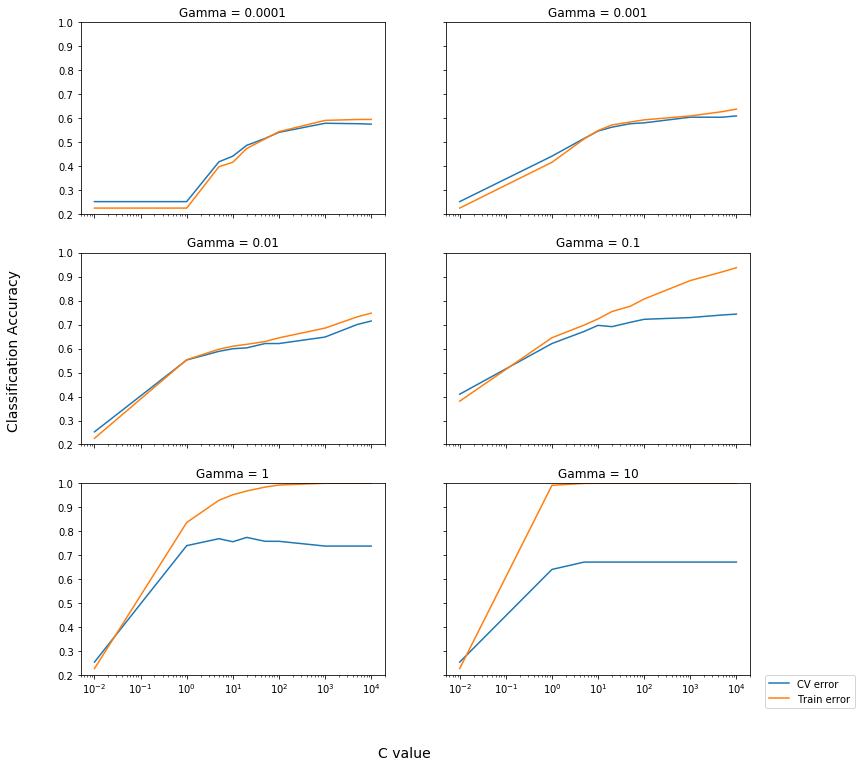

In [33]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(12,12))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = plot_number // 2
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
        ax = axes[row,  column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='upper left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for gamma = 1, and C = 10. We can now create and train an optimized classifier based on these parameters:

In [34]:
clf = svm.SVC(C = 10, gamma = 1)        
clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.75
Optimized adjacent facies classification accuracy = 0.93


Precision and recall are metrics that give more insight into how the classifier performs for individual facies. Precision is the probability that given a classification result for a sample, the sample actually belongs to that class. Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix. The code to do so has been added to the display_confusion_matrix() function:

In [35]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    42     6                                              48
     CSiS     5   112    21     2                                 140
     FSiS     4    17    75           3     1           1         101
     SiSh                 2    22           3           1          28
       MS           1     1     1    25     8     1     3          40
       WS                 1     6     5    44          10          66
        D                 1           1           9     2     1    14
       PS                 1     1     5    16     2    63     3    91
       BS                                                    26    26

Precision  0.82  0.82  0.74  0.69  0.64  0.61  0.75  0.79  0.87  0.76
   Recall  0.88  0.80  0.74  0.79  0.62  0.67  0.64  0.69  1.00  0.75
       F1  0.85  0.81  0.74  0.73  0.63  0.64  0.69  0.74  0.93  0.75


To interpret these results, consider facies SS. In our test set, if a sample was labeled SS the probability the sample was correct is 0.8 (precision). If we know a sample has facies SS, then the probability it will be correctly labeled by the classifier is 0.78 (recall). It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases. The F1 score combines both to give a single measure of relevancy of the classifier results.

These results can help guide intuition for how to improve the classifier results. For example, for a sample with facies MS or mudstone, it is only classified correctly 57% of the time (recall). Perhaps this could be improved by introducing more training samples. Sample quality could also play a role. Facies BS or bafflestone has the best F1 score and relatively few training examples. But this data was handpicked from other wells to provide training examples to identify this facies.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:

In [36]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    48                                                    48
     CSiS         138           2                                 140
     FSiS     4          92           3     1           1         101
     SiSh                 2    22           3           1          28
       MS           1     1          34           1     3          40
       WS                 1     6          59                      66
        D                 1           1          11           1    14
       PS                 1     1     5                84          91
       BS                                                    26    26

Precision  0.92  0.99  0.94  0.71  0.79  0.94  0.92  0.94  0.96  0.93
   Recall  1.00  0.99  0.91  0.79  0.85  0.89  0.79  0.92  1.00  0.93
       F1  0.96  0.99  0.92  0.75  0.82  0.91  0.85  0.93  0.98  0.93


Considering adjacent facies, the F1 scores for all facies types are above 0.9, except when classifying SiSh or marine siltstone and shale. The classifier often misclassifies this facies (recall of 0.66), most often as wackestone.



# Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called blind:

In [37]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3282,3,A1 SH,NEWBY,2826.0,76.34,0.719,7.8,11.00,3.7,1,1.000
3283,3,A1 SH,NEWBY,2826.5,83.74,0.688,9.7,12.55,3.4,1,0.977
3284,3,A1 SH,NEWBY,2827.0,83.19,0.664,10.1,11.95,3.4,1,0.953
3285,3,A1 SH,NEWBY,2827.5,80.44,0.648,10.1,11.15,3.4,1,0.930
3286,3,A1 SH,NEWBY,2828.0,75.42,0.648,9.3,11.45,3.3,1,0.907
...,...,...,...,...,...,...,...,...,...,...,...
3740,6,C LM,NEWBY,3055.0,66.94,0.838,4.0,8.00,4.2,2,0.292
3741,6,C LM,NEWBY,3055.5,54.06,0.823,1.9,5.45,4.3,2,0.281
3742,6,C LM,NEWBY,3056.0,47.87,0.797,0.7,4.85,4.4,2,0.270
3743,6,C LM,NEWBY,3056.5,49.34,0.763,2.3,4.85,4.1,2,0.258


The label vector is just the Facies column:



In [38]:
y_blind = blind['Facies'].values
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
X_blind = scaler.transform(well_features)
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

/home/sudoh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Let's see how we did with the confusion matrix:


In [40]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.10


IndexError: index 9 is out of bounds for axis 0 with size 9

In [41]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

IndexError: index 9 is out of bounds for axis 0 with size 9

In [42]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

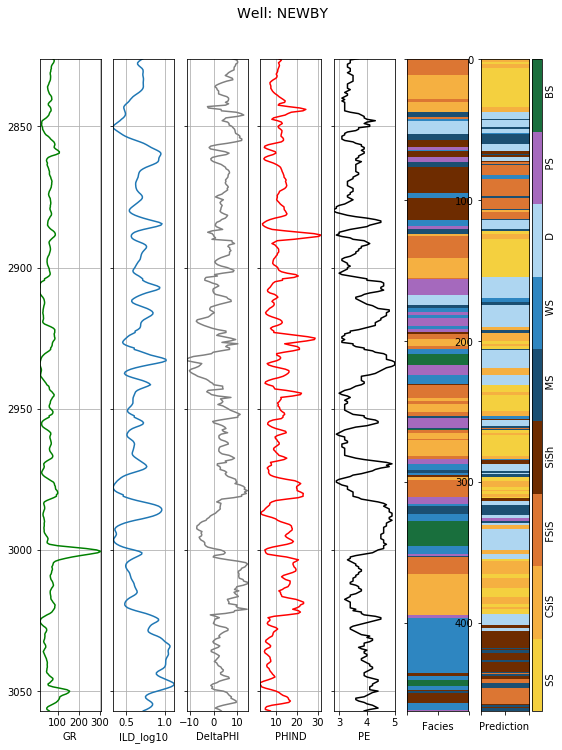

In [43]:
compare_facies_plot(blind, 'Prediction', facies_colors)

# Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data. In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels. It is loaded into a dataframe called test_data.

In [44]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

The data needs to be scaled using the same constants we used for the training data.



In [45]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a Facies column of the test_data dataframe.


In [46]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,2
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,1
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,2
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,2
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,2
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,2


In [47]:
well_data['Well Name'].unique()


[STUART, CRAWFORD]
Categories (2, object): [STUART, CRAWFORD]

We can use the well log plot to view the classification results along with the well logs.



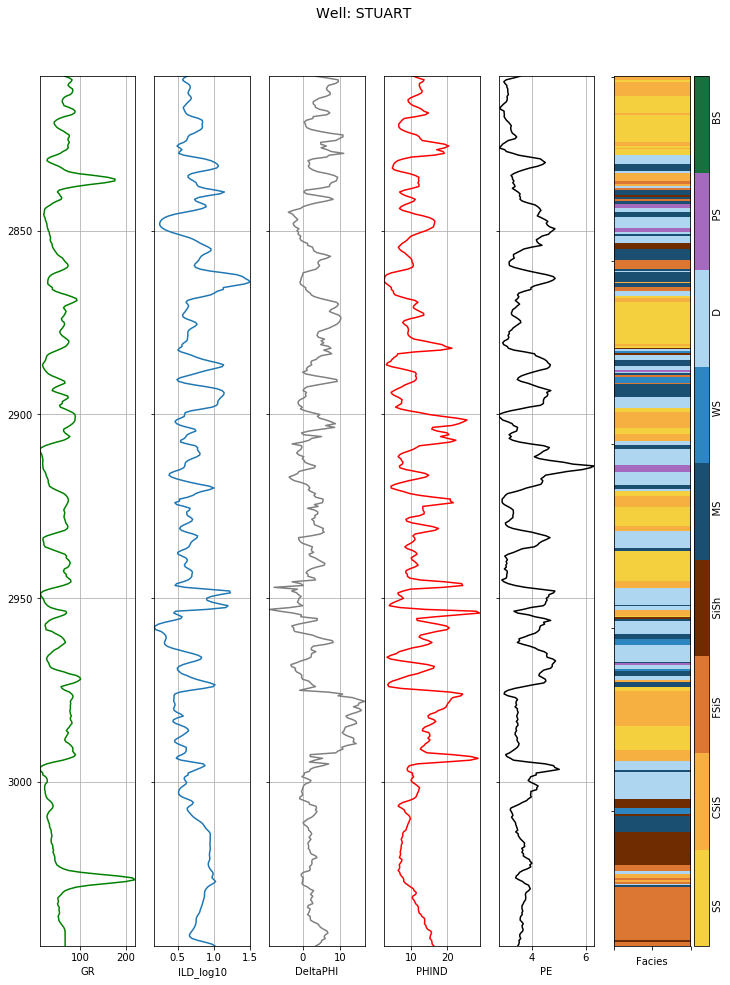

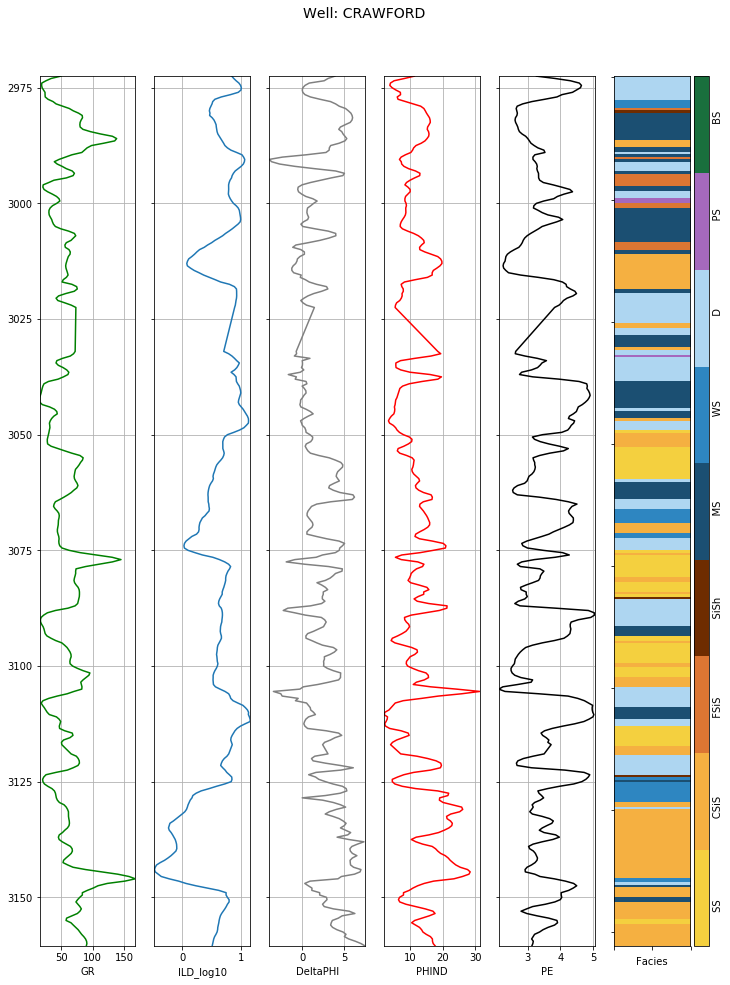

In [48]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

Finally we can write out a csv file with the well data along with the facies classification results.



In [49]:
well_data.to_csv('well_data_with_facies.csv')